In [ ]:
import numpy as np
import pandas as pd

# Plots
import seaborn as sns
import matplotlib.pyplot as plt

# Stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# Misc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

In [ ]:
train = pd.read_csv('https://people.cs.nctu.edu.tw/~c0410766/data/train.csv')
test = pd.read_csv('https://people.cs.nctu.edu.tw/~c0410766/data/test.csv')
train.shape, test.shape


((1460, 81), (1459, 80))

* training data num: 1460

* testing data num:  1459

* attritube num:     79

In [ ]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


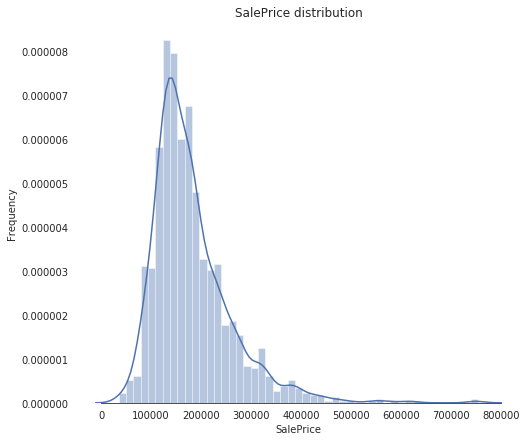

In [ ]:
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))

sns.distplot(train['SalePrice'], color="b");
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)
plt.show()

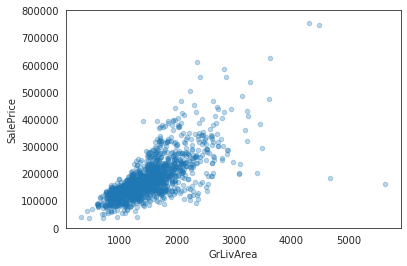

In [ ]:
data = pd.concat([train['SalePrice'], train['GrLivArea']], axis=1)
data.plot.scatter(x='GrLivArea', y='SalePrice', alpha=0.3, ylim=(0,800000));

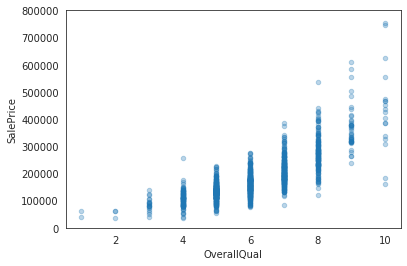

In [ ]:
data = pd.concat([train['SalePrice'], train['OverallQual']], axis=1)
data.plot.scatter(x='OverallQual', y='SalePrice', alpha=0.3, ylim=(0,800000));

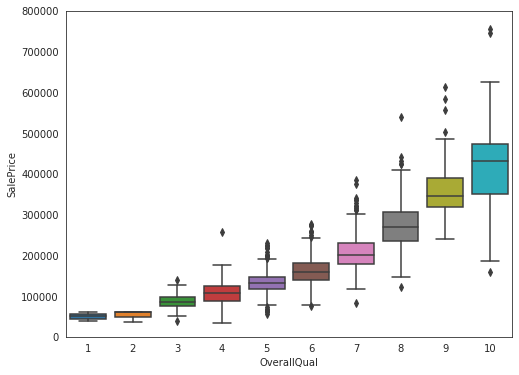

In [ ]:
data = pd.concat([train['SalePrice'], train['OverallQual']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=train['OverallQual'], y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

In [ ]:
# Remove outliers
train.drop(train[(train['OverallQual']<5) & (train['SalePrice']>200000)].index, inplace=True)
train.drop(train[(train['GrLivArea']>4500) & (train['SalePrice']<300000)].index, inplace=True)
train.reset_index(drop=True, inplace=True)

# Feature Engineering

## Normality [ SalePrices ]

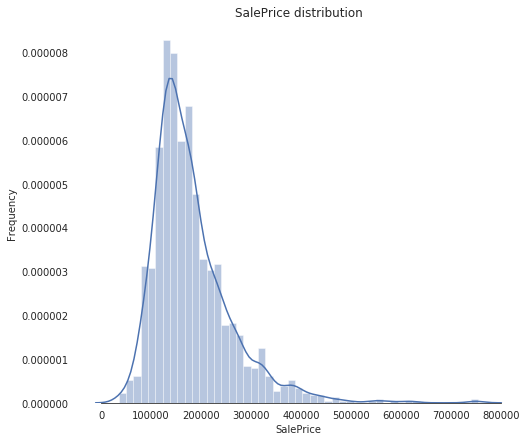

In [ ]:
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution 
sns.distplot(train['SalePrice'], color="b");
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)
plt.show()

In [ ]:
# log(1+x) transform
train["SalePrice"] = np.log1p(train["SalePrice"])

In [ ]:
train["SalePrice"].head()

0    12.247699
1    12.109016
2    12.317171
3    11.849405
4    12.429220
Name: SalePrice, dtype: float64


 mu = 12.02 and sigma = 0.40



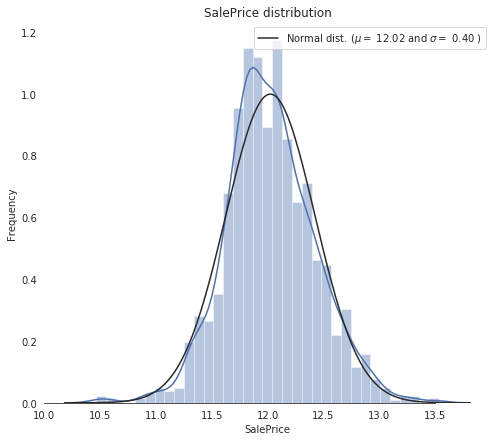

In [ ]:
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution 
sns.distplot(train['SalePrice'] , fit=norm, color="b");

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)

plt.show()

In [ ]:
# Split features and labels
train_labels = train['SalePrice'].reset_index(drop=True)
train_features = train.drop(columns = ['SalePrice', 'Id'], axis=1)
test_features = test.drop(columns = ['Id'], axis = 1)

# Combine train and test features in order to apply the feature transformation pipeline to the entire dataset
all_features = pd.concat([train_features, test_features]).reset_index(drop=True)
all_features.shape

(2916, 79)

## Missing Data Handling

In [ ]:
def missing_situation(df, num = 20):
    count = df.isnull().sum().sort_values(ascending = False)
    percent = (100 * df.isnull().sum() / df.isnull().count() ).sort_values(ascending = False)
    missing = pd.concat([count, percent], axis = 1, keys = ['Count', 'Percent(%)'])
    print( missing.head(num) )

In [ ]:
missing_situation(all_features)

              Count  Percent(%)
PoolQC         2907   99.691358
MiscFeature    2811   96.399177
Alley          2718   93.209877
Fence          2345   80.418381
FireplaceQu    1420   48.696845
LotFrontage     485   16.632373
GarageCond      159    5.452675
GarageQual      159    5.452675
GarageYrBlt     159    5.452675
GarageFinish    159    5.452675
GarageType      157    5.384088
BsmtCond         82    2.812071
BsmtExposure     82    2.812071
BsmtQual         81    2.777778
BsmtFinType2     80    2.743484
BsmtFinType1     79    2.709191
MasVnrType       24    0.823045
MasVnrArea       23    0.788752
MSZoning          4    0.137174
BsmtHalfBath      2    0.068587


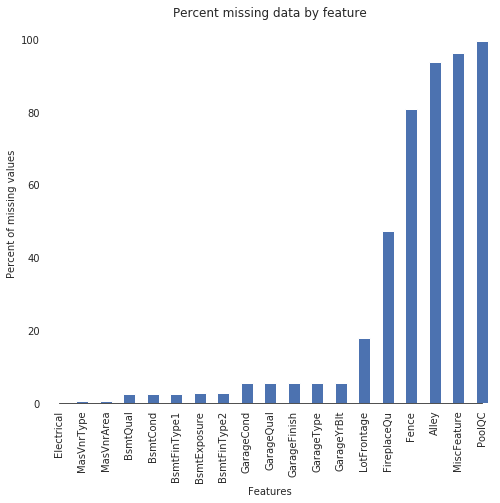

In [ ]:
# Visualize Missing Data
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
sns.set_color_codes(palette='deep')
missing = round(train.isnull().mean() * 100, 2)
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar(color="b")

ax.xaxis.grid(False)
ax.set(ylabel="Percent of missing values")
ax.set(xlabel="Features")
ax.set(title="Percent missing data by feature")
sns.despine(trim=True, left=True)

In [ ]:
# convert numerical to string
all_features['MSSubClass'] = all_features['MSSubClass'].astype(str)
all_features['YrSold'] = all_features['YrSold'].astype(str)
all_features['MoSold'] = all_features['MoSold'].astype(str)

In [ ]:
# Type1: NA refers to "None" [ex. PoolQC: no pool, Fence: no fence, GarageQual: no garage ...]
col1 = ["PoolQC" , "MiscFeature", "Alley", "Fence", "FireplaceQu", "GarageQual", "GarageCond", "GarageFinish", "GarageYrBlt", "GarageType", "BsmtExposure", "BsmtCond", "BsmtQual", "BsmtFinType2", "BsmtFinType1", "MasVnrType"]
for c in col1:
    all_features[c].fillna("None", inplace = True)

# Type2: NA refer to 0 [ex. TotalBsmtSF: no basement so basement area is 0 ...]
col2 = ["MasVnrArea", "BsmtUnfSF", "TotalBsmtSF", "GarageCars", "BsmtFinSF2", "BsmtFinSF1", "GarageArea"]
for c in col2:
    all_features[c].fillna(0, inplace = True)

In [ ]:
missing_situation(all_features, 12)

              Count  Percent(%)
LotFrontage     485   16.632373
MSZoning          4    0.137174
Functional        2    0.068587
Utilities         2    0.068587
BsmtFullBath      2    0.068587
BsmtHalfBath      2    0.068587
Exterior2nd       1    0.034294
SaleType          1    0.034294
KitchenQual       1    0.034294
Electrical        1    0.034294
Exterior1st       1    0.034294
ExterCond         0    0.000000


In [ ]:
# Type3: NA refers to typical ex.('Typ') values
all_features['Functional']  = all_features['Functional'].fillna('Typ')

all_features['KitchenQual'] = all_features['KitchenQual'].fillna("TA")
all_features['Electrical']  = all_features['Electrical'].fillna("SBrkr")

# The mode of a set of values is the value that appears most often
col3 = ["BsmtFullBath", "BsmtHalfBath", "Utilities", "SaleType","Exterior1st", "Exterior2nd"]
for c in col3:
    all_features[c].fillna(all_features[c].mode()[0], inplace = True)

In [ ]:
# Type4: Using other feature to fill
# feature: MSZoning    <= MSSubClass
all_features['MSZoning'] = all_features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
# feature: LotFrontage <= Neighborhood + LotAreaCut(LotArea)
all_features['LotAreaCut'] = pd.qcut(all_features.LotArea, 10)
all_features['LotFrontage'] = all_features.groupby(['LotAreaCut','Neighborhood'])['LotFrontage'].transform(lambda x: x.fillna(x.median()))
# however, since some 'Neighborhood' and 'LotAreaCut' combinations are not available, so just fill these na values with LotAreaCut
all_features['LotFrontage'] = all_features.groupby(['LotAreaCut'])['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [ ]:
# no missing data anymore
missing_situation(all_features, 5)

               Count  Percent(%)
LotAreaCut         0         0.0
SaleCondition      0         0.0
RoofMatl           0         0.0
Exterior1st        0         0.0
Exterior2nd        0         0.0


In [ ]:
# drop unwanted columns
all_features.drop("LotAreaCut", axis=1, inplace=True)

## Fix skewed features

In [ ]:
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = []
for i in all_features.columns:
    if all_features[i].dtype in numeric_dtypes:
        numeric.append(i)

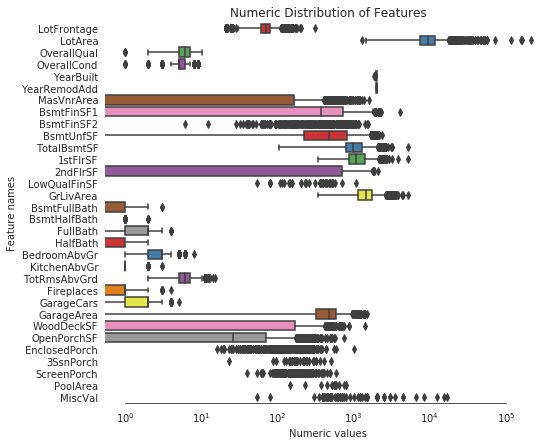

In [ ]:
# Create box plots for all numeric features
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log")
ax = sns.boxplot(data=all_features[numeric] , orient="h", palette="Set1")
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric values")
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)

In [ ]:
# Find skewed numerical features
skew_features = all_features[numeric].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

print("There are {} numerical features with Skew > 0.5 :".format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew' :high_skew})
skew_features.head(10)

There are 25 numerical features with Skew > 0.5 :


MiscVal          21.935910
PoolArea         17.685603
LotArea          13.262550
LowQualFinSF     12.082427
3SsnPorch        11.370087
KitchenAbvGr      4.299698
BsmtFinSF2        4.143683
EnclosedPorch     4.001570
ScreenPorch       3.944305
BsmtHalfBath      3.929197
dtype: float64

In [ ]:
# Normalize skewed features
for i in skew_index:
    all_features[i] = boxcox1p(all_features[i], boxcox_normmax(all_features[i] + 1))

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3538: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficent may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:486: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  **kws)


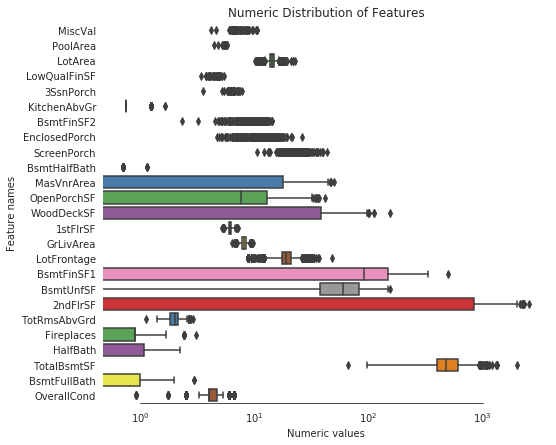

In [ ]:
# Let's make sure we handled all the skewed values
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log")
ax = sns.boxplot(data=all_features[skew_index] , orient="h", palette="Set1")
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric values")
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)

## Create interesting features & Feature transformations

In [ ]:
all_features['BsmtFinType1_Unf'] = 1*(all_features['BsmtFinType1'] == 'Unf')
all_features['HasWoodDeck'] = (all_features['WoodDeckSF'] == 0) * 1
all_features['HasOpenPorch'] = (all_features['OpenPorchSF'] == 0) * 1
all_features['HasEnclosedPorch'] = (all_features['EnclosedPorch'] == 0) * 1
all_features['Has3SsnPorch'] = (all_features['3SsnPorch'] == 0) * 1
all_features['HasScreenPorch'] = (all_features['ScreenPorch'] == 0) * 1
all_features['YearsSinceRemodel'] = all_features['YrSold'].astype(int) - all_features['YearRemodAdd'].astype(int)
all_features['Total_Home_Quality'] = all_features['OverallQual'] + all_features['OverallCond']
all_features = all_features.drop(['Utilities', 'Street', 'PoolQC',], axis=1)
all_features['TotalSF'] = all_features['TotalBsmtSF'] + all_features['1stFlrSF'] + all_features['2ndFlrSF']
all_features['YrBltAndRemod'] = all_features['YearBuilt'] + all_features['YearRemodAdd']

all_features['Total_sqr_footage'] = (all_features['BsmtFinSF1'] + all_features['BsmtFinSF2'] +
                                 all_features['1stFlrSF'] + all_features['2ndFlrSF'])
all_features['Total_Bathrooms'] = (all_features['FullBath'] + (0.5 * all_features['HalfBath']) +
                               all_features['BsmtFullBath'] + (0.5 * all_features['BsmtHalfBath']))
all_features['Total_porch_sf'] = (all_features['OpenPorchSF'] + all_features['3SsnPorch'] +
                              all_features['EnclosedPorch'] + all_features['ScreenPorch'] +
                              all_features['WoodDeckSF'])
all_features['TotalBsmtSF'] = all_features['TotalBsmtSF'].apply(lambda x: np.exp(6) if x <= 0.0 else x)
all_features['2ndFlrSF'] = all_features['2ndFlrSF'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)
all_features['GarageArea'] = all_features['GarageArea'].apply(lambda x: np.exp(6) if x <= 0.0 else x)
all_features['GarageCars'] = all_features['GarageCars'].apply(lambda x: 0 if x <= 0.0 else x)
all_features['LotFrontage'] = all_features['LotFrontage'].apply(lambda x: np.exp(4.2) if x <= 0.0 else x)
all_features['MasVnrArea'] = all_features['MasVnrArea'].apply(lambda x: np.exp(4) if x <= 0.0 else x)
all_features['BsmtFinSF1'] = all_features['BsmtFinSF1'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)

all_features['haspool'] = all_features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
all_features['has2ndfloor'] = all_features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
all_features['hasgarage'] = all_features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
all_features['hasbsmt'] = all_features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
all_features['hasfireplace'] = all_features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [ ]:
def logs(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol=pd.Series(np.log(1.01+res[l])).values)   
        res.columns.values[m] = l + '_log'
        m += 1
    return res

log_features = ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF',
                 'TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea',
                 'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr',
                 'TotRmsAbvGrd','Fireplaces','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF',
                 'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','YearRemodAdd','TotalSF']

all_features = logs(all_features, log_features)

In [ ]:
def squares(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol=pd.Series(res[l]*res[l]).values)   
        res.columns.values[m] = l + '_sq'
        m += 1
    return res 

squared_features = ['YearRemodAdd', 'LotFrontage_log', 
              'TotalBsmtSF_log', '1stFlrSF_log', '2ndFlrSF_log', 'GrLivArea_log',
              'GarageCars_log', 'GarageArea_log']
all_features = squares(all_features, squared_features)

## Encode categorical features

In [ ]:
all_features = pd.get_dummies(all_features).reset_index(drop=True)
all_features.shape

(2916, 482)

In [ ]:
all_features.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,BsmtFinType1_Unf,HasWoodDeck,HasOpenPorch,HasEnclosedPorch,Has3SsnPorch,HasScreenPorch,YearsSinceRemodel,Total_Home_Quality,...,Fence_MnPrv,Fence_MnWw,Fence_None,MiscFeature_Gar2,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,MoSold_1,MoSold_10,MoSold_11,MoSold_12,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,18.198423,14.054263,7,3.990332,2003,2003,19.438231,143.920047,0.0,30.010267,422.114947,5.929136,1026.391549,0.0,8.339939,0.993263,0.000000,2,1.068921,3,0.750955,2.262646,0.000000,2.0,548.0,0.000000,12.071122,0.000000,0.0,0.0,0.0,0.0,0,1,0,1,1,1,5,10.990332,...,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,20.738688,14.347269,6,5.997763,1976,1976,54.598150,181.454701,0.0,44.168168,593.327333,6.224032,665.141633,0.0,7.962253,0.000000,0.710938,2,0.000000,3,0.750955,1.997107,0.903299,2.0,460.0,56.101584,0.000000,0.000000,0.0,0.0,0.0,0.0,0,0,1,1,1,1,31,11.997763,...,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,18.724173,14.716277,7,3.990332,2001,2002,17.773262,110.299851,0.0,56.942688,449.676734,5.984244,1041.273148,0.0,8.394288,0.993263,0.000000,2,1.068921,3,0.750955,1.997107,0.903299,2.0,608.0,0.000000,9.894344,0.000000,0.0,0.0,0.0,0.0,0,1,0,1,1,1,6,10.990332,...,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,17.299666,14.335210,7,3.990332,1915,1970,54.598150,61.728759,0.0,64.863764,378.526862,6.017495,905.115976,0.0,8.345041,0.993263,0.000000,1,0.000000,3,0.750955,2.137976,0.903299,3.0,642.0,0.000000,8.960357,16.025062,0.0,0.0,0.0,0.0,0,1,0,0,1,1,36,10.990332,...,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
4,21.382268,15.277957,8,3.990332,2000,2000,25.411668,136.439665,0.0,61.217218,544.803190,6.150533,1273.975831,0.0,8.654709,0.993263,0.000000,2,1.068921,4,0.750955,2.374499,0.903299,3.0,836.0,42.189389,14.259706,0.000000,0.0,0.0,0.0,0.0,0,0,0,1,1,1,8,11.990332,...,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


In [ ]:
# Remove any duplicated column names
all_features = all_features.loc[:,~all_features.columns.duplicated()]

## Recreate training and test sets

In [ ]:
X = all_features.iloc[:len(train_labels), :]
X_test = all_features.iloc[len(train_labels):, :]
X.shape, train_labels.shape, X_test.shape

((1457, 481), (1457,), (1459, 481))

## Setup cross validation and define error metrics

In [ ]:
# Setup cross validation folds
kf = KFold(n_splits=12, random_state=42, shuffle=True)

In [ ]:
# Define error metrics
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, train_labels, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

## Training Models

### Setup

In [ ]:
# Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

In [ ]:
# XGBoost Regressor
xgboost = XGBRegressor(learning_rate=0.01,
                       n_estimators=6000,
                       max_depth=4,
                       min_child_weight=0,
                       gamma=0.6,
                       subsample=0.7,
                       colsample_bytree=0.7,
                       objective='reg:squarederror',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=27,
                       reg_alpha=0.00006,
                       random_state=42)
# objective='reg:linear'

# Random Forest
rf = RandomForestRegressor(n_estimators=1200,
                          max_depth=15,
                          min_samples_split=5,
                          min_samples_leaf=5,
                          max_features=None,
                          oob_score=True,
                          random_state=42)
# Support Vector regression
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003))

### Training (get cross_validation accuracy)

In [ ]:
# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore")

scores = {}

In [ ]:
# XGBoost Regressor
score = cv_rmse(xgboost)
print("xgboost: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['xgb'] = (score.mean(), score.std())

In [ ]:
# Random Forest
score = cv_rmse(rf)
print("rf: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['rf'] = (score.mean(), score.std())

KeyboardInterrupt: ignored

In [ ]:
# Support Vector Regression
score = cv_rmse(svr)
print("SVR: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['svr'] = (score.mean(), score.std())

SVR: 0.1096 (0.0160)


### Fit the training model

In [ ]:
print('xgboost')
xgb_model_full_data = xgboost.fit(X, train_labels)

xgboost


In [ ]:
print('RandomForest')
rf_model_full_data = rf.fit(X, train_labels)

RandomForest


In [ ]:
print('Svr')
svr_model_full_data = svr.fit(X, train_labels)

Svr


### Blending Predictions of different model

In [ ]:
def Blending_pred(x):
    return ( 0.3 * xgb_model_full_data.predict(x) +
             0.2 * rf_model_full_data.predict(x) +
             0.5 * svr_model_full_data.predict(x) )

In [ ]:
blended_score = rmsle(train_labels, Blending_pred(X))
scores['blended'] = (blended_score, 0)
print('RMSLE score on train data:')
print(blended_score)

RMSLE score on train data:
0.08886134256320613


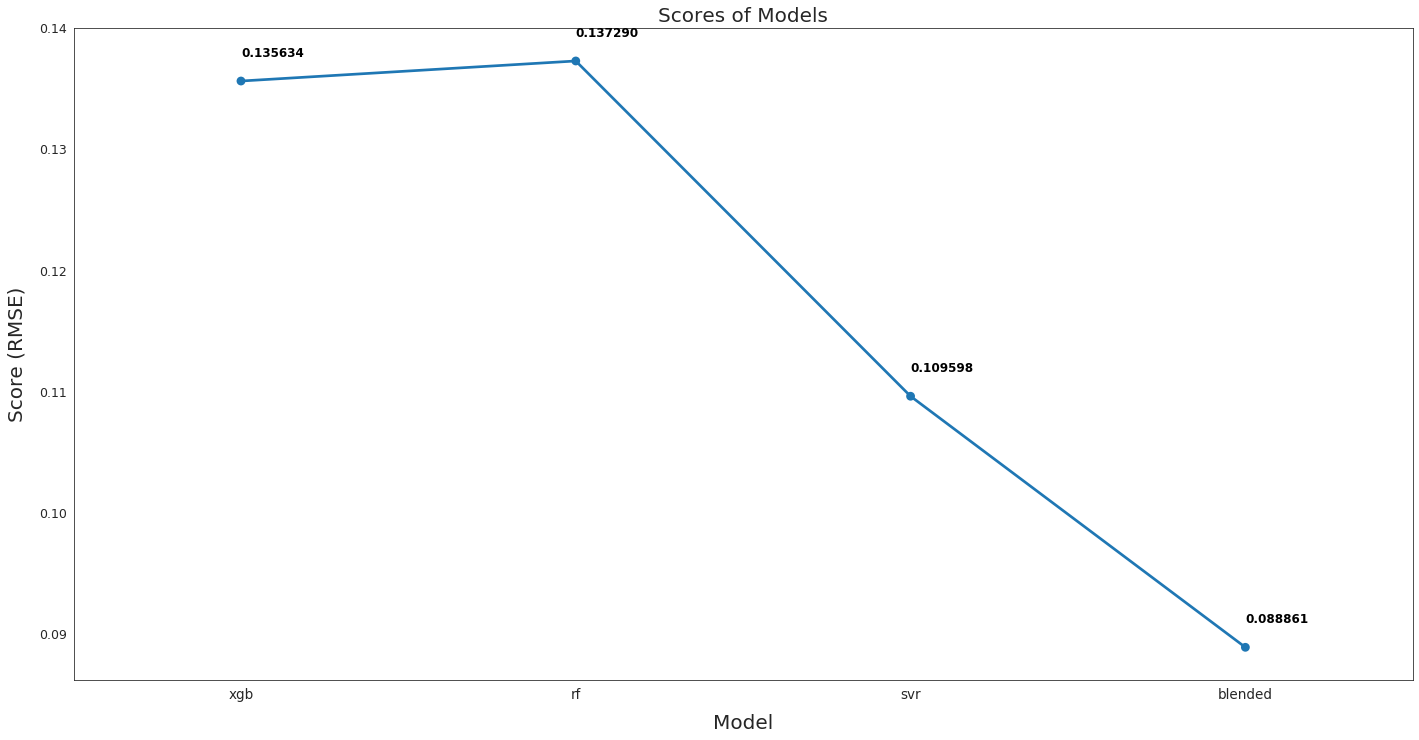

In [ ]:
# Plot the predictions for each model
sns.set_style("white")
fig = plt.figure(figsize=(24, 12))

ax = sns.pointplot(x=list(scores.keys()), y=[score for score, _ in scores.values()], markers=['o'], linestyles=['-'])
for i, score in enumerate(scores.values()):
    ax.text(i, score[0] + 0.002, '{:.6f}'.format(score[0]), horizontalalignment='left', size='large', color='black', weight='semibold')

plt.ylabel('Score (RMSE)', size=20, labelpad=12.5)
plt.xlabel('Model', size=20, labelpad=12.5)
plt.tick_params(axis='x', labelsize=13.5)
plt.tick_params(axis='y', labelsize=12.5)

plt.title('Scores of Models', size=20)

plt.show()

# Output

In [ ]:
submission = pd.read_csv('/content/sample_submission.csv')
submission.shape

(1459, 2)

In [ ]:
submission.iloc[:,1] = np.floor(np.expm1(Blending_pred(X_test)))
submission.to_csv("submission.csv", index=False)

# Reference

1.
https://www.kaggle.com/lavanyashukla01/how-i-made-top-0-3-on-a-kaggle-competition

2.
https://www.kaggle.com/marsggbo/kaggle#%E4%B8%80%E3%80%81%E6%98%8E%E7%A1%AE%E7%9B%AE%E7%9A%84

3.
https://www.kaggle.com/massquantity/all-you-need-is-pca-lb-0-11421-top-4
(https://blog.csdn.net/wydyttxs/article/details/79680814)

4.
https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python
(http://studyai.site/2018/03/09/%E3%80%90%E7%BF%BB%E8%AF%91%E3%80%91kaggle%E7%AB%9E%E8%B5%9B%20%E6%88%BF%E4%BB%B7%E9%A2%84%E6%B5%8B/)
